<a href="https://colab.research.google.com/github/nachomadra01/TFG/blob/main/Grano_ABF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install atomai

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

#Función deconvolución
def add_border(matrix, border_width):
    rows, cols = matrix.shape
    bordered_matrix = np.zeros((rows + border_width*2, cols + border_width*2))
    bordered_matrix[border_width:-border_width, border_width:-border_width] = matrix
    return bordered_matrix

def conv(Exp):
    import scipy.signal
    A = [[0.003, 0.013, 0.022, 0.013, 0.003], [0.013, 0.060, 0.098, 0.060, 0.013], [0.022, 0.099, 0.162, 0.098, 0.022],
         [0.013, 0.060, 0.098, 0.060, 0.013], [0.003, 0.013, 0.022, 0.013, 0.003]]
    F = scipy.signal.convolve2d(Exp, A, mode='full', boundary='fill', fillvalue=0)
    F = F[2:-2, 2:-2]

    return F

#Función de encontrar máximos locales
def row_col_max_finder(graph,threshold):
    #mask=np.array([1,1,1,1,0,1,1,1,1])
    mask=np.array([1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1])
    if np.sqrt(mask.size).is_integer():
        side=int(np.sqrt(mask.size))
        mask=mask.reshape(side,side)
        mask_short=side//2

    graph2=np.pad(graph,[mask_short,mask_short])
    graph1=graph2.copy()
    rows,cols=graph2.shape
    for row in range(mask_short,rows-mask_short):
        for col in range(mask_short,cols-mask_short):
            if graph1[row,col]>threshold:

                graph2[row,col]=np.max(graph1[row-mask_short:row+mask_short+1:,col-mask_short:col+mask_short+1]*mask)

    bool_array=np.array(graph1>graph2,dtype=int)[mask_short:-mask_short,mask_short:-mask_short]
    row_max,col_max=np.where(bool_array>0)
    return row_max, col_max

#Función de refinamiento de máximos locales
def max_ref(F,row_max,col_max):
    x_new = np.zeros(len(row_max))
    y_new = np.zeros(len(row_max))
    for i in range(len(row_max)):
        I_tot = 0
        I_promx = 0
        I_promy = 0
        x_new[i] = 0
        y_new[i] = 0

        G = F[row_max[i] - 3:row_max[i] + 3, col_max[i] - 3:col_max[i] + 3] - 0.02
        I_tot = np.sum(G)
        for j in range(6):
            for k in range(6):
                I_promx = I_promx + G[int(j), int(k)] * int(k - 3)
                I_promy = I_promy + G[int(j), int(k)] * int(j - 3)
        x_new[i] = I_promx / I_tot
        y_new[i] = I_promy / I_tot
    row_max1 = row_max+y_new
    col_max1 = col_max+x_new
    return  row_max1,col_max1
#Clasificación de subredes para 3 especies
def subredes3(F,row_max,col_max,row_max1,col_max1):
    # Plot para estimar el número de clases
    B = np.zeros(len(row_max))
    B = F[row_max, col_max]
    plt.hist(B)
    plt.show()
    # Criterio de la zona de confianza para una clase
    W = np.unique(B)
    lim = np.mean(W)
    print(lim)
    # Se define el número de clases y los arrays de las sublattices
    n_cl = 3
    A1 = []
    A2 = []
    B1 = []
    B2 = []
    C1 = []
    C2 = []
    for i in range(len(row_max)):
        if B[i] < lim:
            A1.append(row_max[i])
            A2.append(col_max[i])
        if lim < B[i] < 2 * lim:
            B1.append(row_max1[i])
            B2.append(col_max1[i])
        if 2 * lim < B[i] :
            C1.append(row_max1[i])
            C2.append(col_max1[i])
    col_row_a = np.concatenate(([A1], [A2]))
    col_row_b = np.concatenate(([B1], [B2]))
    col_row_c = np.concatenate(([C1], [C2]))
    #Plot
    plt.imshow(F)
    plt.colorbar()
    plt.scatter(A2, A1, marker='+', color='red', label='O')
    plt.scatter(B2, B1, marker='+', color='blue', label='Ti')
    plt.scatter(C2, C1, marker='+', color='green', label='Sr')
    plt.legend()
    plt.show()

    return col_row_a,col_row_b,col_row_c

def train_prep3(ground,p,train_size):
    from atomai.utils import create_lattice_mask, extract_patches_
    from atomai.transforms import datatransform
    lattice_im = ground.item()['lattice_img']
    xy_atoms_a = ground.item()['lattice_coord_a']
    xy_atoms_b = ground.item()['lattice_coord_b']
    xy_atoms_c = ground.item()['lattice_coord_c']

    lattice_im = (lattice_im - lattice_im.min()) / (lattice_im.max() - lattice_im.min())

    latt_x_min = 0
    latt_x_max = lattice_im.shape[0]
    radius = 5

    xy_atoms_a_true = np.delete(xy_atoms_a,
                                np.where((xy_atoms_a < latt_x_min + radius) | (xy_atoms_a > latt_x_max - radius))[1],
                                axis=-1)
    xy_atoms_b_true = np.delete(xy_atoms_b,
                                np.where((xy_atoms_b < latt_x_min + radius) | (xy_atoms_b > latt_x_max - radius))[1],
                                axis=-1)
    xy_atoms_c_true = np.delete(xy_atoms_c,
                                np.where((xy_atoms_c < latt_x_min + radius) | (xy_atoms_c > latt_x_max - radius))[1],
                                axis=-1)

    # Se crean las ground truth con el comando create_lattice_mask
    lattice_mask_a = create_lattice_mask(lattice_im, xy_atoms_a_true.T)
    lattice_mask_b = create_lattice_mask(lattice_im, xy_atoms_b_true.T)
    lattice_mask_c = create_lattice_mask(lattice_im, xy_atoms_c_true.T)

    multiclass = True

    if multiclass:
        lattice_mask_backgr = 1 - np.clip((lattice_mask_a + lattice_mask_b + lattice_mask_c), 0.0001, 1)
        lattice_mask = np.concatenate(
            (lattice_mask_a[..., None],
             lattice_mask_b[..., None],
             lattice_mask_c[..., None],
             lattice_mask_backgr[..., None]),  # we need to add a background class
            axis=-1)
    else:
        lattice_mask = np.clip((lattice_mask_a + lattice_mask_b + lattice_mask_c), 0.0001, 1)

    images_all, labels_all = extract_patches_(
        lattice_im, lattice_mask, patch_size=256, num_patches=p, random_state=42)

    ##########    Cuidado, incluir este parametro dado que cambia en el augmentor                              ############
    images_all_b = np.copy(images_all)
    labels_all_b = np.copy(labels_all)

    # For a single class case, we still need to explicitly specify the single channel
    labels_all_b = labels_all_b[..., None] if np.ndim(labels_all_b) == 3 else labels_all_b
    # Number of channels in masked data (the training images have a single channel)
    ch = labels_all_b.shape[-1]
    # Define image distortion/noise parameters
    zoom = 3  # zoom factor
    poisson = [30, 70]  # P noise range (scaled units)
    gauss = [20, 100]  # G noise range (scaled units)
    blur = [1, 50]  # Blurring range (scaled units)
    contrast = [5, 14]  # contrast range (< 10 is brighter, > 10 is darker)
    salt_and_pepper = [1, 10]  # min/max amount of salted/peppered pixels (scaled units)

    # Run the augmentor
    imaug = datatransform(
        n_channels=ch, dim_order_in='channel_last', dim_order_out='channel_first',
        gauss_noise=gauss, poisson_noise=poisson, salt_and_pepper=salt_and_pepper,
        contrast=contrast, blur=blur, zoom=zoom, rotation=True,
        squeeze_channels=True, seed=42)
    images_all_b, labels_all_b = imaug.run(images_all_b, labels_all_b)

    from sklearn.model_selection import train_test_split
    images_train_b, images_test_all_b, labels_train_b, labels_test_all_b = train_test_split(
        images_all_b, labels_all_b, train_size=train_size,  random_state=42)

    np.savez('ground_truth.npz',
             X_train=images_all_b, X_test=images_test_all_b, y_train=labels_all_b, y_test=labels_test_all_b)

    return images_train_b, images_test_all_b ,labels_all_b,labels_test_all_b

def segment(dataset,expdata,cycle):
    import atomai as aoi
    images = dataset['X_train']
    labels = dataset['y_train']
    images_test = dataset['X_test']
    labels_test = dataset['y_test']
    n = 5  # number of images to plot

    n = n + 1
    fig = plt.figure(figsize=(30, 8))
    for i in range(1, n):
        ax = fig.add_subplot(2, n, i)
        ax.imshow(images[i - 1, 0, :, :], cmap='gray')
        ax.set_title('Augmented image ' + str(i))
        ax.grid(alpha=0.5)
        ax = fig.add_subplot(2, n, i + n)
        ax.imshow(labels[i - 1, :, :], interpolation='Gaussian', cmap='jet')
        ax.set_title('Ground truth ' + str(i))
        ax.grid(alpha=0.75)
    plt.show()
    #Model training
    model = aoi.models.Segmentor(nb_classes=4)
    model.fit(images, labels,
              images_test,labels_test,  # training data
              training_cycles=cycle, compute_accuracy=True, swa=False  # training parameters
             )
    #Segmentation prediction

    nn_output, coordinates = model.predict(expdata)

    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 12))
    ax1.imshow(expdata, cmap='gray', origin="lower")
    ax2.imshow(nn_output.squeeze(), origin="lower")
    plt.show()
    aoi.utils.plot_coord(expdata, coordinates[0], fsize=12)
    return nn_output,coordinates

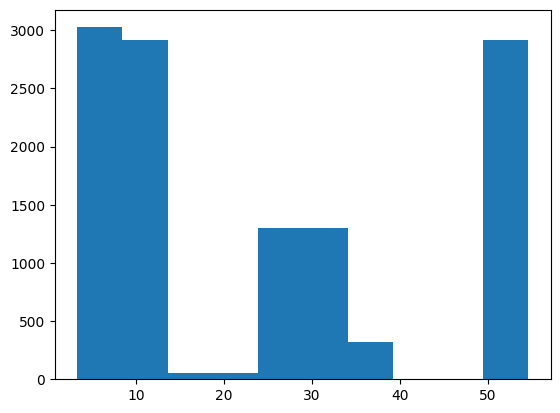

20.748004801419317


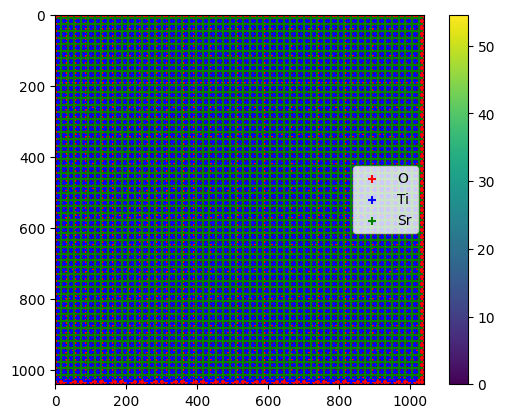

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

#Cargamos la imagen
Exp = np.load('Prueba_3.npy')
Exp = (np.exp(4*(abs(1 - Exp)-0.2)/np.amax(abs(1 - Exp)-0.2)))
Exp = add_border(Exp,7)
F = Exp

#Máximos locales
row_max, col_max = row_col_max_finder(F,0)
row_max1,col_max1 = max_ref(F,row_max,col_max)
#Clasificación en subredes
col_row_a,col_row_b,col_row_c = subredes3(F,row_max,col_max,row_max1,col_max1)

dicion={}
dicion['lattice_img']=F
dicion['lattice_coord_a']=col_row_a
dicion['lattice_coord_b']=col_row_b
dicion['lattice_coord_c']=col_row_c
np.save("Prueba_ground_truth", dicion)

ground = np.load('Prueba_ground_truth.npy',allow_pickle=True)
images_train_b, images_test_all_b ,labels_all_b,labels_test_all_b = train_prep3(ground,5000,0.8)

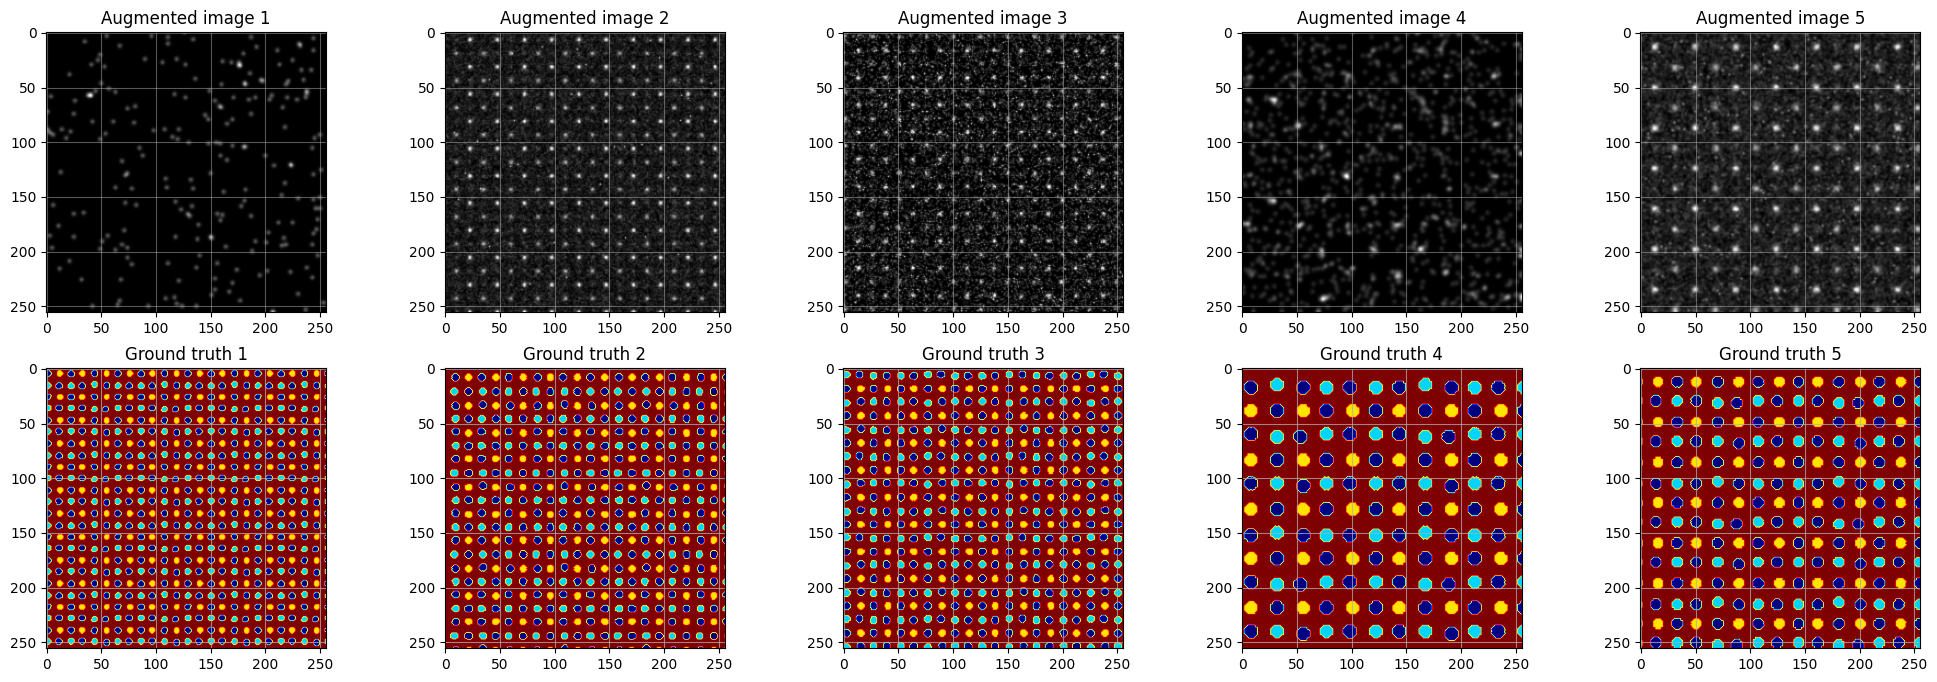

C:\Users\RedPC\anaconda3\lib\site-packages\atomai\trainers\trainer.py:653: UserWarning: No GPU found. The training can be EXTREMELY slow
  warnings.warn(


Epoch 1/500 ... Training loss: 1.4039 ... Test loss: 1.3089 ... Train Accuracy: 0.0454 ... Test Accuracy: 0.0288 ... GPU memory usage: N/A / N/A
Epoch 100/500 ... Training loss: 0.7503 ... Test loss: 0.7706 ... Train Accuracy: 0.3531 ... Test Accuracy: 0.4025 ... GPU memory usage: N/A / N/A
Epoch 200/500 ... Training loss: 0.5437 ... Test loss: 0.5802 ... Train Accuracy: 0.422 ... Test Accuracy: 0.4391 ... GPU memory usage: N/A / N/A
Epoch 300/500 ... Training loss: 0.491 ... Test loss: 0.45 ... Train Accuracy: 0.4316 ... Test Accuracy: 0.4626 ... GPU memory usage: N/A / N/A
Epoch 400/500 ... Training loss: 0.4196 ... Test loss: 0.4774 ... Train Accuracy: 0.4658 ... Test Accuracy: 0.4548 ... GPU memory usage: N/A / N/A
Epoch 500/500 ... Training loss: 0.4708 ... Test loss: 0.5007 ... Train Accuracy: 0.4231 ... Test Accuracy: 0.4022 ... GPU memory usage: N/A / N/A
Model (final state) evaluation loss: 0.4781
Model (final state) IoU: 0.4247
Plotting training history


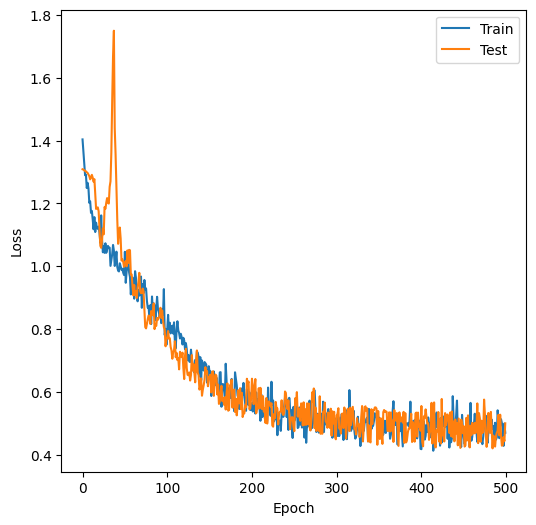

In [ ]:
import atomai as aoi
dataset = np.load('ground_truth.npz')
expdata = np.load('Prueba_3.npy')

images = dataset['X_train']
labels = dataset['y_train']
images_test = dataset['X_test']
labels_test = dataset['y_test']
n = 5  # number of images to plot

n = n + 1
fig = plt.figure(figsize=(30, 8))
for i in range(1, n):
    ax = fig.add_subplot(2, n, i)
    ax.imshow(images[i - 1, 0, :, :], cmap='gray')
    ax.set_title('Augmented image ' + str(i))
    ax.grid(alpha=0.5)
    ax = fig.add_subplot(2, n, i + n)
    ax.imshow(labels[i - 1, :, :], interpolation='Gaussian', cmap='jet')
    ax.set_title('Ground truth ' + str(i))
    ax.grid(alpha=0.75)
plt.show()
#Model training
model = aoi.models.Segmentor(nb_classes=4)
model.fit(images, labels,
            images_test,labels_test,  # training data
            training_cycles=500, compute_accuracy=True, swa=False  # training parameters
         )

(256, 313, 4)


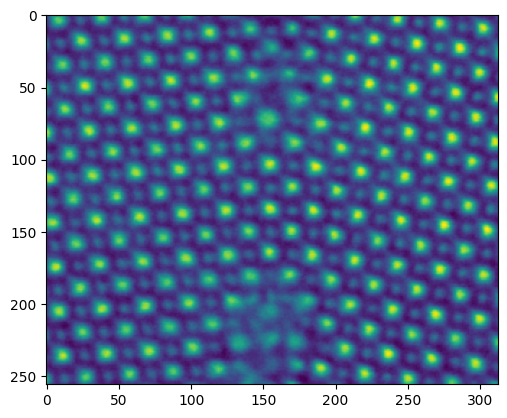

In [ ]:
from PIL import Image
img = Image.open('Exp_5.png')
graph5 = np.asarray(img)
print(graph5.shape)
graph5 = abs(1 - graph5[:,:,0]/255)-0.2
graph5=graph5/np.amax(graph5)
plt.imshow(graph5)
plt.show()


In [ ]:
nn_output5,coordinates5 = model.predict(graph5)

Batch 1/1
1 image was decoded in approximately 0.1356 seconds


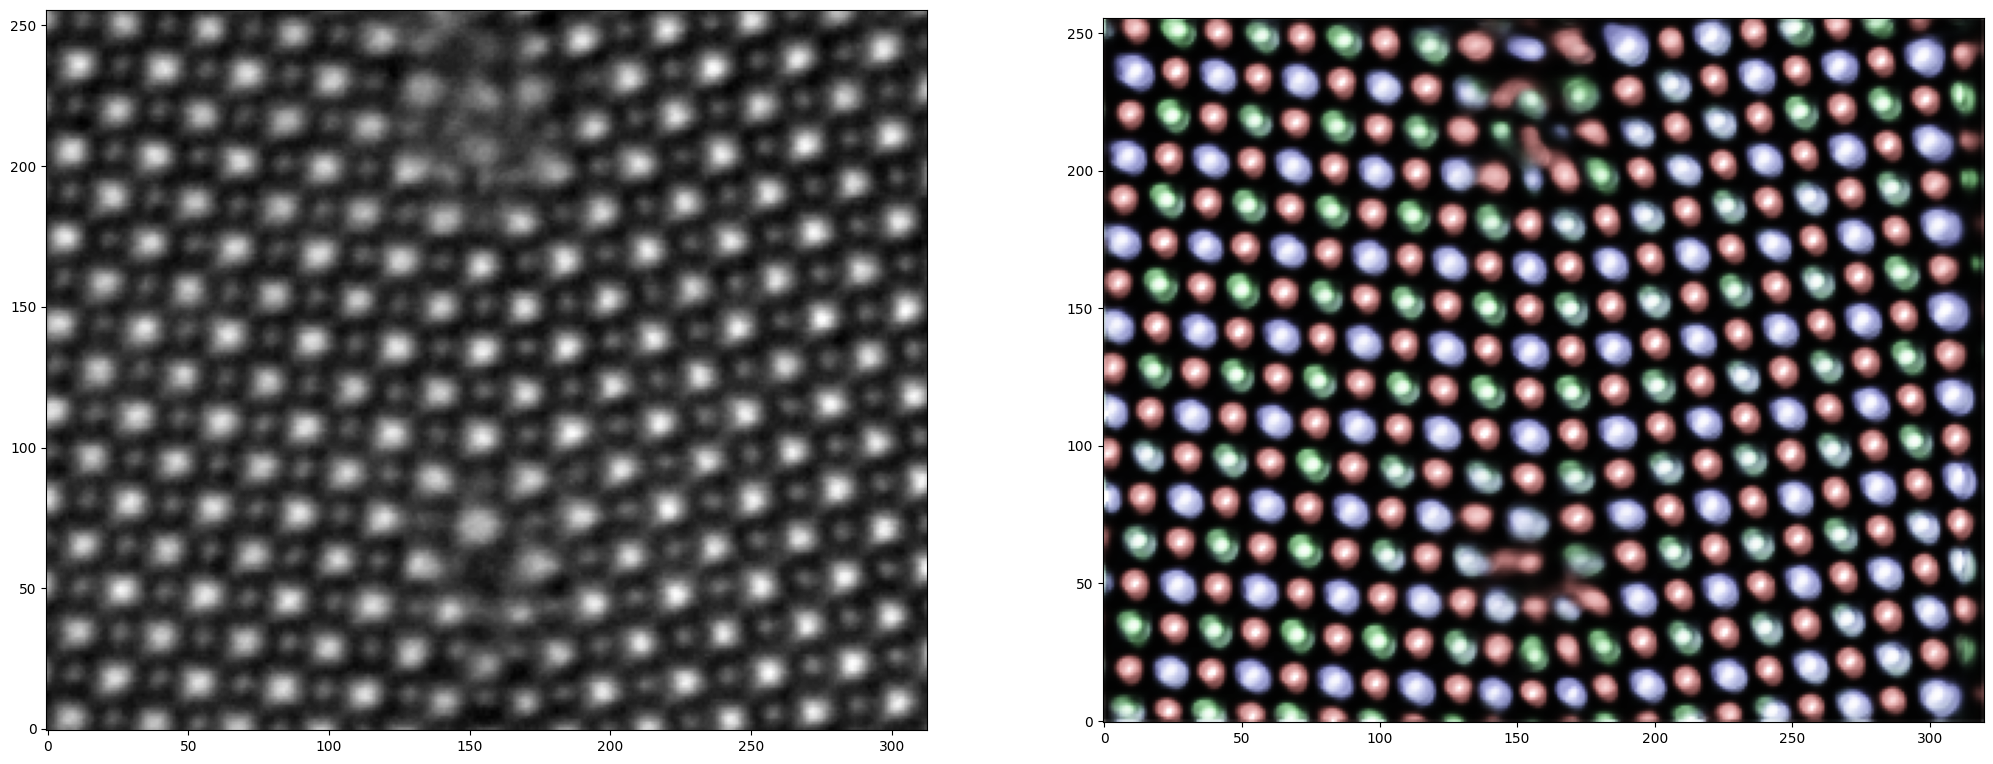

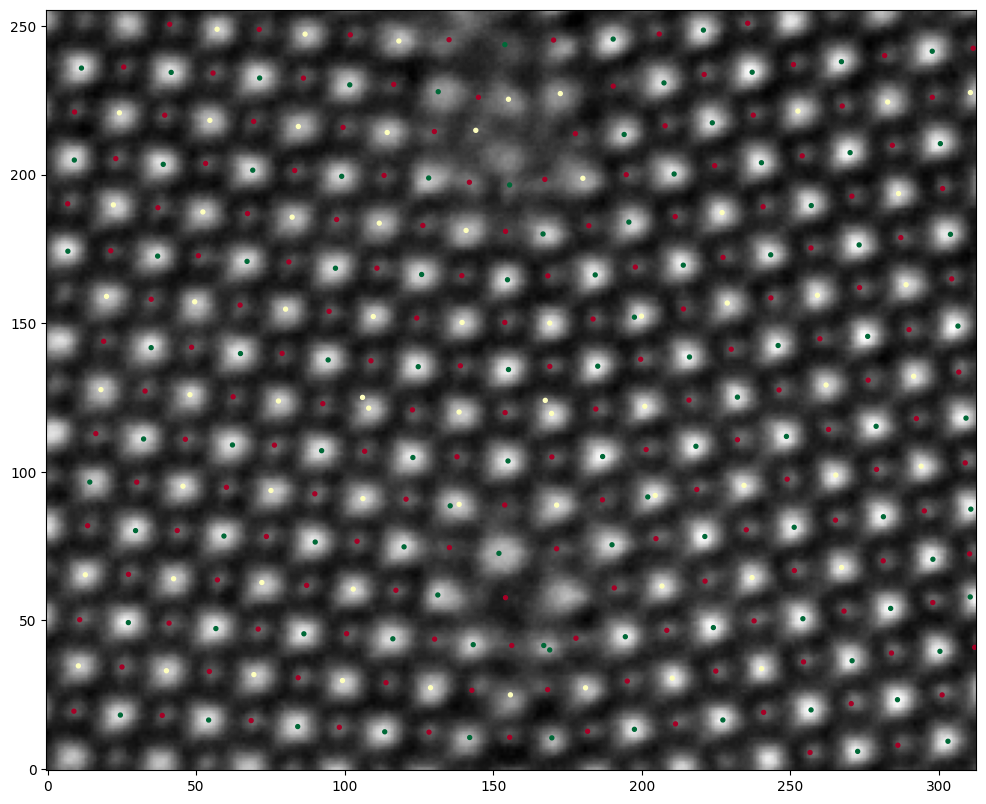

In [ ]:
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 12))
    ax1.imshow(graph5, cmap='gray', origin="lower")
    ax2.imshow(nn_output5.squeeze(), origin="lower")
    plt.show()
    aoi.utils.plot_coord(graph5, coordinates5[0], fsize=12)

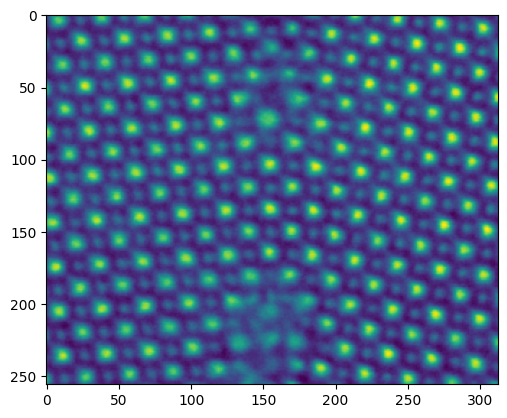

In [ ]:
graph6 = np.exp(4*graph5)
plt.imshow(graph5)
plt.show()

In [ ]:
nn_output6,coordinates6 = model.predict(graph6)

Batch 1/1
1 image was decoded in approximately 0.1357 seconds


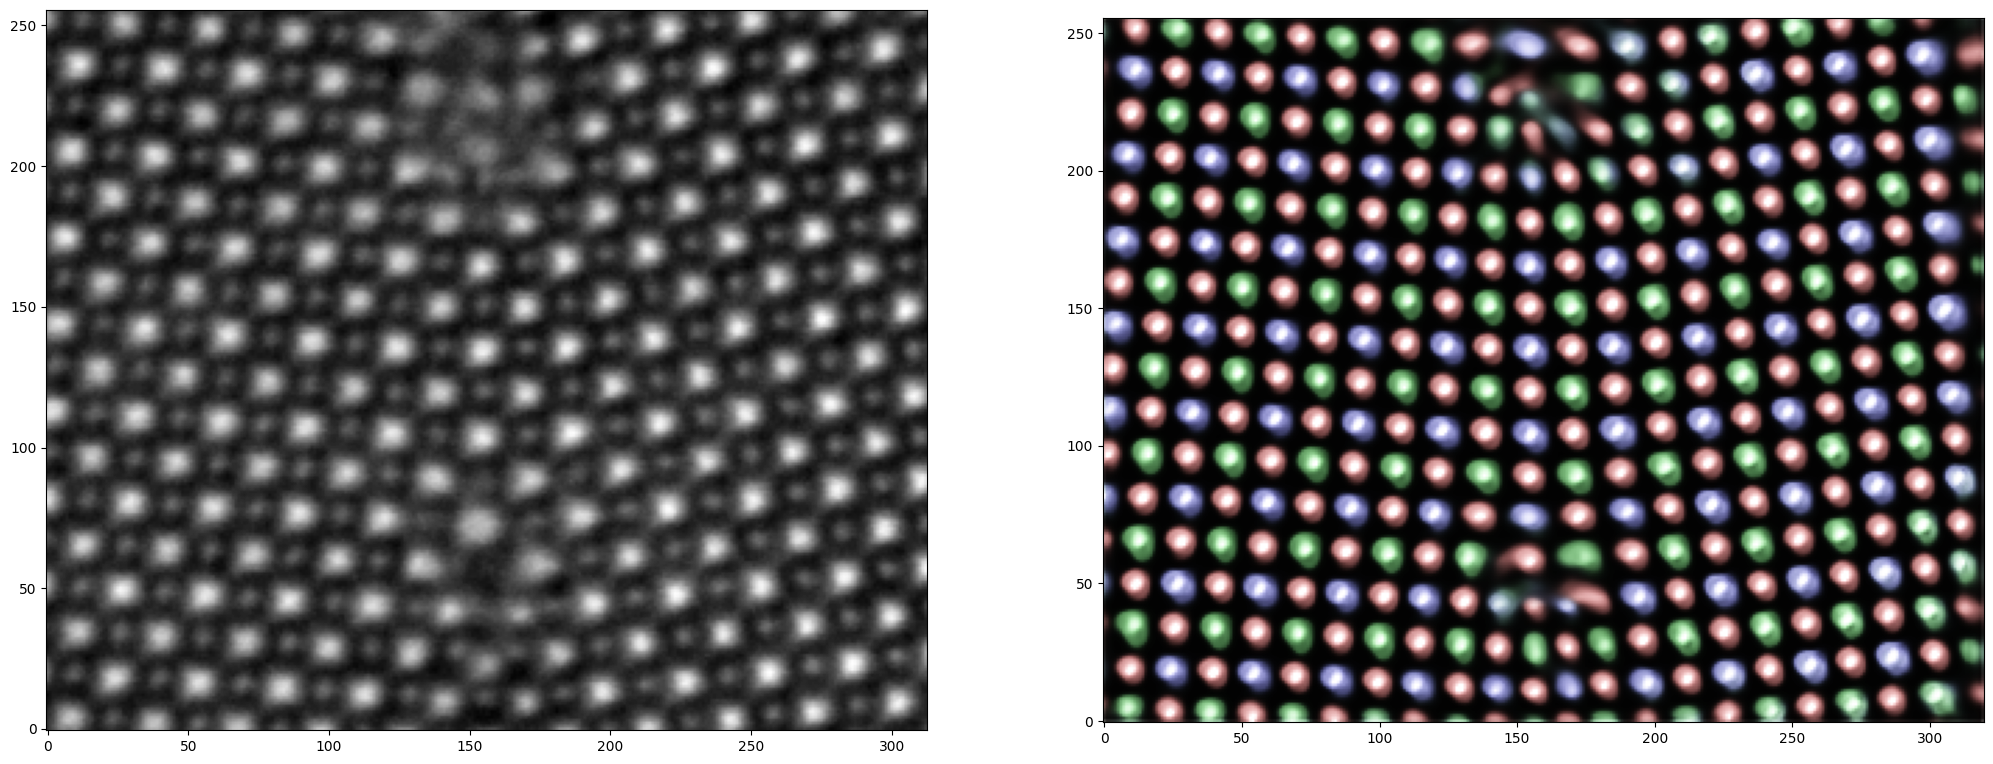

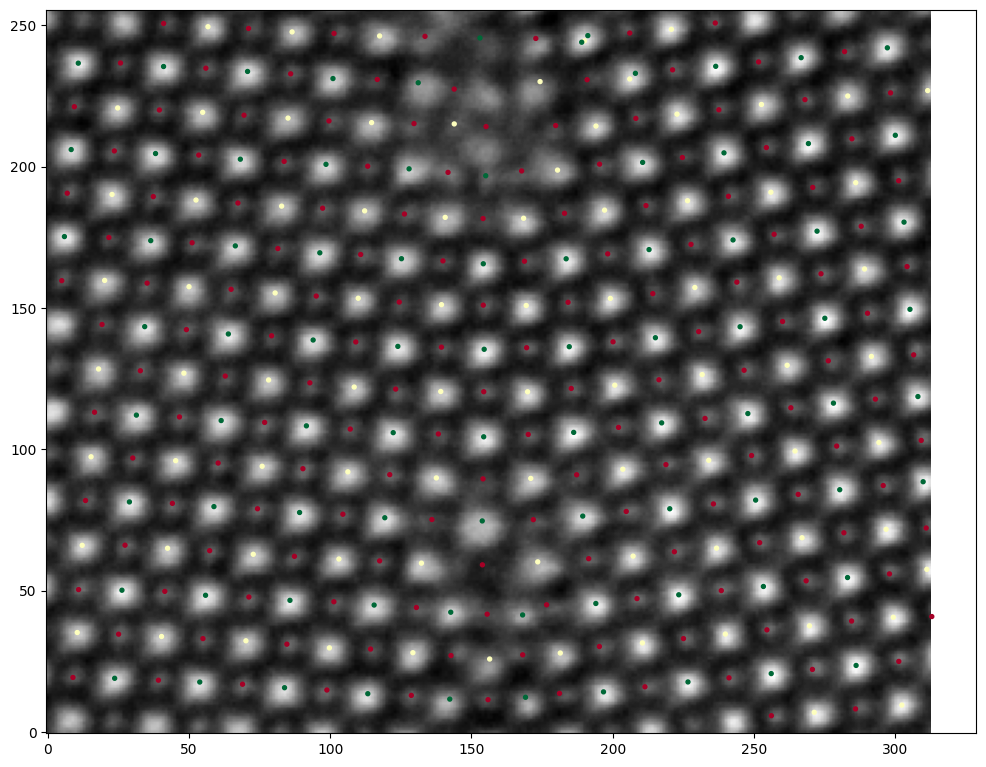

In [ ]:
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 12))
    ax1.imshow(graph5, cmap='gray', origin="lower")
    ax2.imshow(nn_output6.squeeze(), origin="lower")
    plt.show()
    aoi.utils.plot_coord(graph5, coordinates6[0], fsize=12)

In [ ]:
print(coordinates6[0])

[[  5.71794872 256.1025641    0.        ]
 [  8.12820513 285.87179487   0.        ]
 [ 11.38888889 155.86111111   0.        ]
 [ 12.91111111 128.71111111   0.        ]
 [ 13.61111111 181.13888889   0.        ]
 [ 14.81395349  98.8372093    0.        ]
 [ 15.95       211.375        0.        ]
 [ 16.85365854  69.           0.        ]
 [ 18.28888889  39.24444444   0.        ]
 [ 19.24390244   9.           0.        ]
 [ 19.11627907 241.11627907   0.        ]
 [ 22.0952381  270.61904762   0.        ]
 [ 24.92857143 301.19047619   0.        ]
 [ 27.         142.75609756   0.        ]
 [ 27.25714286 168.11428571   0.        ]
 [ 29.29787234 114.29787234   0.        ]
 [ 30.20454545 195.25         0.        ]
 [ 31.02222222  84.68888889   0.        ]
 [ 33.          55.           0.        ]
 [ 33.         225.           0.        ]
 [ 34.56521739  25.15217391   0.        ]
 [ 36.09090909 254.52272727   0.        ]
 [ 39.21276596 284.4893617    0.        ]
 [ 40.8        312.86666667   0.  